### Scrap notebook

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline


from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler


sns.set_theme(style='darkgrid')
# read in the json files
portfolio = pd.read_json('../data/raw/portfolio.json', orient='records', lines=True)
profile = pd.read_json('../data/raw/profile.json', orient='records', lines=True)
transcript = pd.read_json('../data/raw/transcript.json', orient='records', lines=True)

In [2]:
# Get offer ids from 'value' column, convert to float, and store in new column
offer_ids = dict()
indx = list(transcript[transcript['event']!='transaction'].index)

for ind in indx: 
    offer_id = list(transcript.iloc[ind]['value'].values())[0]
    offer_ids.update({ind:offer_id})
    
# Make dataframe from dictionary of index, offer_id strings     
offer_id_df = pd.DataFrame.from_dict(offer_ids, orient='index', columns=['offer_ids'])

# Concat transcript_mod and offer_id_df dataframes
transcript_mod = pd.concat([transcript, offer_id_df], axis=1, ignore_index=False)

# rename column 'id' as offer_ids to remain consistent with transcript df
portfolio = portfolio.rename(columns={'id':'offer_ids'})

# merge transcript and portfolio dataframes
transcript_portfolio = transcript_mod.merge(portfolio[['offer_ids', 'offer_type']], on='offer_ids', how='left')

# filter transcript_portfolio to get transcripts corresponding to BOGO offers 
bogo = transcript_portfolio[transcript_portfolio['offer_type']=='bogo']

# count the number of events per person
bogos_per_person = bogo.groupby('person')['event'].value_counts().unstack()

# fill Nan in offer completed with 0 since these people did not complete any offer 
bogos_per_person['offer completed'].fillna(0, inplace=True)

# add column with number of event
bogos_per_person['completed_per_view'] = bogos_per_person['offer completed'] / bogos_per_person['offer viewed']

# replace completed_per_view nans with 0 since these people did not view the offer. NEED TO THINK MORE ABOUT THIS
bogos_per_person['completed_per_view'].fillna(0, inplace=True)

In [2]:
# rename column 'id' to 'person' to remain consistent with transcript
profile = profile.rename(columns={'id':'person'})
# Remove people was ages > 99
profile = profile[profile['age'] <= 99]

# Remove people with income > 1000000
profile = profile[profile['income'] < 1000000.0]

# Binarise age based on criteria old=1, young=0
def age_group(age):
    if age < 25:
        return '< 25 years'
    
    if age < 35:
        return '25 - 35 years'
    
    if age < 45:
        return '36 - 45 years'
    
    if age < 66: 
        return '46 - 66 years'
    
    else: 
        return '67+ years'

profile['age_group'] = profile['age'].apply(lambda x:age_group(x))

# Binarise income based on criteria rich=1, poor=0
def income_group(income):
    if income < 50001: 
        return 'low income'
    if income < 70001:
        return 'med - low income'
    if income < 90001:
        return 'high - med income'
    else:
        return 'high income'

profile['income_group'] = profile['income'].apply(lambda x:income_group(x))

# select columns needed for training model
profile_subset = profile[['person','income_group','age_group', 'gender']]

# reset index to allow ease concatanation with transformed ohe data
profile_subset = profile_subset.reset_index()

profile_subset.drop('index', axis=1, inplace=True)

bogos_per_person_demo = bogos_per_person.merge(profile_subset, left_index=True, right_on='person', how='left').set_index('person')

bogos_per_person_demo.dropna(subset=['age_group'], inplace=True)

NameError: name 'bogos_per_person' is not defined

If completed_per_view > 1, replace value with 1, since they would have completed more items than they viewed but only the ones they viewed should count. 

In [4]:
bogos_per_person_demo['completed_per_view'] = np.where((bogos_per_person_demo['completed_per_view'] > 1),1, bogos_per_person_demo['completed_per_view'])

If completed_per_view > 0.5 then these people respond to offers. 
If completed_per_view <= 0.5, then these people do not respond to offers.
Add column with responds 1 for > 0.5, 0 for <=0.5

In [5]:
def setting_response(cpv):
    if cpv <= 0.5: 
        return 0 
    else: 
        return 1
    
bogos_per_person_demo['responds'] = bogos_per_person_demo['completed_per_view'].apply(lambda x:setting_response(x))

In [6]:
bogos_per_person_demo['responds'].value_counts()

1    6927
0    6142
Name: responds, dtype: int64

In [7]:
bogos_per_person_demo.drop(columns=['offer completed', 'offer received', 'offer viewed', 'completed_per_view'], axis=1, inplace=True)

In [8]:
bogos_per_person_demo.isna().sum()

income_group    0
age_group       0
gender          0
responds        0
dtype: int64

Use pipeline and include onehotencoding in pipeline

In [9]:
# THE FOLLOWING CELLS WORK BUT THE CELLS ABOVE WERE EDITED SO NEED TO ADJUST THIS
# intantiate OHE
categorical_encoder = OneHotEncoder(handle_unknown='ignore')
    
# List categorical variables in to be OHE
categorical_columns = ['income_group','age_group','gender']

preprocessing = ColumnTransformer(
        [
            ('cat', categorical_encoder, categorical_columns),
        ]
    )


In [10]:
model_rf = Pipeline(
    [
        ('preprocess', preprocessing),
        #('oversample', ros),
        ('classifier', RandomForestClassifier())
    ]
    
)

In [11]:
X = bogos_per_person_demo.drop('responds', axis=1)
y = bogos_per_person_demo['responds']

## Do train test split, see results 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42);

In [37]:
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['True', 'False'])

In [38]:
print(accuracy)
print(report)

0.631981637337414
              precision    recall  f1-score   support

        True       0.63      0.59      0.61      1270
       False       0.63      0.67      0.65      1344

    accuracy                           0.63      2614
   macro avg       0.63      0.63      0.63      2614
weighted avg       0.63      0.63      0.63      2614



In [14]:
ohe = model.named_steps['preprocess'].named_transformers_['cat']
feature_names = ohe.get_feature_names_out(categorical_columns)
feature_names

array(['income_group_high - med income', 'income_group_high income',
       'income_group_low income', 'income_group_med - low income',
       'age_group_25 - 35 years', 'age_group_36 - 45 years',
       'age_group_46 - 66 years', 'age_group_67+ years',
       'age_group_< 25 years', 'gender_F', 'gender_M', 'gender_O'],
      dtype=object)

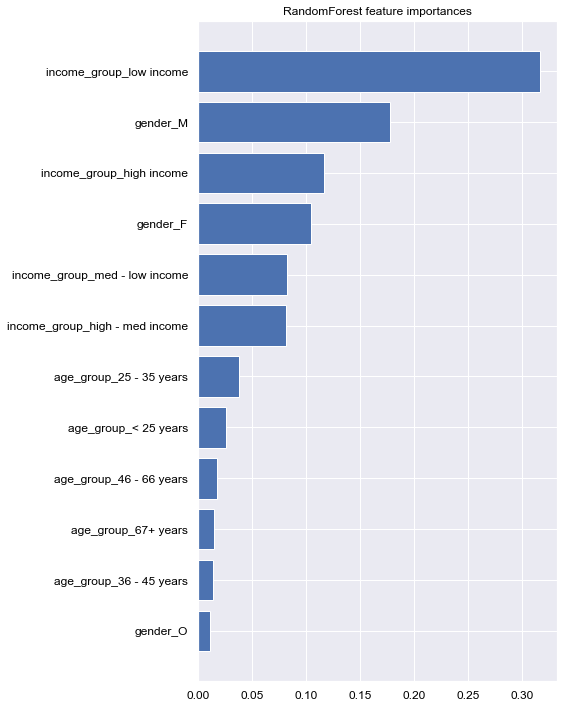

In [15]:
tree_feature_importances = model.named_steps['classifier'].feature_importances_

sorted_idx = tree_feature_importances.argsort()
    
y_ticks = np.arange(0, len(feature_names))
    
    # Plot feature importance
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(8,10))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx], color='black', fontsize=12)
ax.set_title('RandomForest feature importances', color='black', fontsize=12)
plt.xticks(color='black', fontsize=12)
fig.tight_layout()
plt.show()

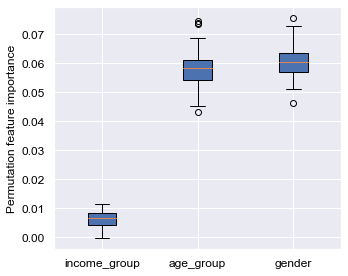

In [17]:
result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

    # Plot permutation importance
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(5,4))
ax.boxplot(result.importances[sorted_idx].T, vert=True, labels=X_test.columns[sorted_idx], patch_artist=True)
    #ax.set_ylabel('Relative feature importance', color='black', fontsize=12)
ax.set_ylabel('Permutation feature importance', color='black', fontsize=12)
plt.xticks(color='black', fontsize=12)
ax.set_xticklabels(['income_group','age_group','gender'], color='black', fontsize=12)
plt.yticks(color='black', fontsize=12)
fig.tight_layout()
plt.show()

In [13]:
from sklearn.svm import SVC

In [14]:
model_svc = Pipeline(
    [
        ('preprocess', preprocessing),
        #('oversample', ros),
        ('classifier', SVC())
    ]
    
)

In [15]:
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['True', 'False'])

In [16]:
print(accuracy)
print(report)

0.6308339709257842
              precision    recall  f1-score   support

        True       0.62      0.61      0.62      1270
       False       0.64      0.65      0.64      1344

    accuracy                           0.63      2614
   macro avg       0.63      0.63      0.63      2614
weighted avg       0.63      0.63      0.63      2614



In [19]:
from sklearn.svm import LinearSVC
model_lsvc = Pipeline(
    [
        ('preprocess', preprocessing),
        #('oversample', ros),
        ('classifier', LinearSVC())
    ]
    
)
model_lsvc.fit(X_train, y_train)
y_pred = model_lsvc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['True', 'False'])

print(accuracy)
print(report)

0.6300688599846977
              precision    recall  f1-score   support

        True       0.62      0.61      0.62      1270
       False       0.64      0.65      0.64      1344

    accuracy                           0.63      2614
   macro avg       0.63      0.63      0.63      2614
weighted avg       0.63      0.63      0.63      2614



In [14]:
from sklearn.ensemble import AdaBoostClassifier
model_adb = Pipeline(
    [
        ('preprocess', preprocessing),
        #('oversample', ros),
        ('classifier', AdaBoostClassifier())
    ]
    
)
model_adb.fit(X_train, y_train)
y_pred = model_adb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['True', 'False'])

print(accuracy)
print(report)

0.6300688599846977
              precision    recall  f1-score   support

        True       0.62      0.61      0.62      1270
       False       0.64      0.65      0.64      1344

    accuracy                           0.63      2614
   macro avg       0.63      0.63      0.63      2614
weighted avg       0.63      0.63      0.63      2614



Tune random forest classifier 
Tune svm 
Tune adaboostclassifier

Look into including informational and discount to produce multioutput classifier like disaster response project

In [17]:
# Get offer ids from 'value' column, convert to float, and store in new column
offer_ids = dict()
indx = list(transcript[transcript['event']!='transaction'].index)

for ind in indx: 
    offer_id = list(transcript.iloc[ind]['value'].values())[0]
    offer_ids.update({ind:offer_id})
    
# Make dataframe from dictionary of index, offer_id strings     
offer_id_df = pd.DataFrame.from_dict(offer_ids, orient='index', columns=['offer_ids'])

# Concat transcript_mod and offer_id_df dataframes
transcript_mod = pd.concat([transcript, offer_id_df], axis=1, ignore_index=False)

# rename column 'id' as offer_ids to remain consistent with transcript df
portfolio = portfolio.rename(columns={'id':'offer_ids'})

# merge transcript and portfolio dataframes
transcript_portfolio = transcript_mod.merge(portfolio[['offer_ids', 'offer_type']], on='offer_ids', how='left')

offers = ['bogo', 'discount']
# filter transcript_portfolio to get transcripts corresponding to BOGO offers 
offer = transcript_portfolio[transcript_portfolio['offer_type'].isin(offers)]

# count the number of events per person
#bogos_per_person = bogo.groupby('person')['event'].value_counts().unstack()

# fill Nan in offer completed with 0 since these people did not complete any offer 
#bogos_per_person['offer completed'].fillna(0, inplace=True)

# add column with number of event
#bogos_per_person['completed_per_view'] = bogos_per_person['offer completed'] / bogos_per_person['offer viewed']

# replace completed_per_view nans with 0 since these people did not view the offer. NEED TO THINK MORE ABOUT THIS
#bogos_per_person['completed_per_view'].fillna(0, inplace=True)

In [18]:
offer.drop(['value','time', 'offer_ids'], axis=1, inplace=True)

/Users/SamaraSadeek/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
offer_per_person = offer.groupby(['person','offer_type'])['event'].value_counts().unstack()

offer_per_person['offer completed'].fillna(0, inplace=True)

In [20]:
offer_per_person['completed_per_view'] = offer_per_person['offer completed']/ offer_per_person['offer viewed']

In [21]:
offer_per_person['completed_per_view'].fillna(0, inplace=True)

In [22]:
def setting_response(cpv):
    if cpv <= 0.5: 
        return 0 
    else: 
        return 1
    
offer_per_person['responds'] = offer_per_person['completed_per_view'].apply(lambda x:setting_response(x))

In [23]:
offer_df = offer_per_person.unstack()

In [24]:
offer_df = offer_df['responds']

In [25]:
offer_df.dropna(inplace=True)

In [26]:
offer_df = offer_df.reset_index()

In [27]:
offer_df['discount'].value_counts()

1.0    7148
0.0    5861
Name: discount, dtype: int64

In [28]:
offer_per_person_demo = offer_df.merge(profile_subset, left_on='person',right_on='person', how='left').set_index('person')

offer_per_person_demo

,bogo,discount,income_group,age_group,gender
person,,,,,
0009655768c64bdeb2e877511632db8f,1.0,1.0,high - med income,25 - 35 years,M
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,med - low income,36 - 45 years,O
0020c2b971eb4e9188eac86d93036a77,1.0,1.0,high - med income,46 - 66 years,F
0020ccbbb6d84e358d3414a3ff76cffd,1.0,1.0,med - low income,< 25 years,F
004b041fbfe44859945daa2c7f79ee64,1.0,1.0,high - med income,46 - 66 years,F
...,...,...,...,...,...
fff29fb549084123bd046dbc5ceb4faa,1.0,1.0,high income,46 - 66 years,F
fff3ba4757bd42088c044ca26d73817a,1.0,1.0,high - med income,67+ years,F
fff7576017104bcc8677a8d63322b5e1,0.0,1.0,high - med income,67+ years,M


In [29]:
parameters = {'n_estimators': [140,142,145], 'criterion':('gini', 'entropy'), 'max_features':['auto', 'sqrt']}
clf = RandomForestClassifier(class_weight={0: 0.4, 1: 1})
cv = GridSearchCV(clf, parameters)

IndentationError: unexpected indent (<ipython-input-29-1c790d99d491>, line 2)

In [30]:
X = offer_per_person_demo.drop(['bogo', 'discount'], axis=1)
y = offer_per_person_demo[['bogo', 'discount']]

## Do train test split, see results 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42);

In [60]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#rus = RandomUnderSampler()
clf = MultiOutputClassifier(RandomForestClassifier())

pipeline = Pipeline(
    [
        ('preprocess', preprocessing),
        #('undersample', rus),
        ('classifier', clf),
    ]
    
)

parameters = {'classifier__estimator__n_estimators': [120, 140, 160], 'classifier__estimator__criterion':('gini', 'entropy')}

cv = GridSearchCV(pipeline, param_grid=parameters)


cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['bogo', 'discount'])

print(accuracy)
print(report)

0.46041506533435816
              precision    recall  f1-score   support

        bogo       0.64      0.64      0.64      1215
    discount       0.64      0.81      0.72      1437

   micro avg       0.64      0.73      0.68      2652
   macro avg       0.64      0.73      0.68      2652
weighted avg       0.64      0.73      0.68      2652
 samples avg       0.44      0.48      0.44      2652



/Users/SamaraSadeek/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/SamaraSadeek/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
cv.best_params_

{'classifier__estimator__criterion': 'gini',
 'classifier__estimator__n_estimators': 140}

In [62]:
clf = MultiOutputClassifier(RandomForestClassifier())

pipeline = Pipeline(
    [
        ('preprocess', preprocessing),
        #('undersample', rus),
        ('classifier', clf),
    ]
    
)

parameters = {'classifier__estimator__max_features': ('sqrt', 'log2'), 'classifier__estimator__min_samples_leaf':[6, 8, 10]}

cv = GridSearchCV(pipeline, param_grid=parameters)


cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['bogo', 'discount'])

print(accuracy)
print(report)
cv.best_params_

0.46041506533435816
              precision    recall  f1-score   support

        bogo       0.64      0.64      0.64      1215
    discount       0.64      0.81      0.72      1437

   micro avg       0.64      0.73      0.68      2652
   macro avg       0.64      0.73      0.68      2652
weighted avg       0.64      0.73      0.68      2652
 samples avg       0.44      0.48      0.44      2652



/Users/SamaraSadeek/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/SamaraSadeek/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'classifier__estimator__max_features': 'log2',
 'classifier__estimator__min_samples_leaf': 6}

In [58]:
from sklearn.metrics import multilabel_confusion_matrix
clf = MultiOutputClassifier(RandomForestClassifier())

pipeline = Pipeline(
    [
        ('preprocess', preprocessing),
        #('undersample', rus),
        ('classifier', clf),
    ]
    
)

#parameters = {'classifier__estimator__max_features': ('sqrt'), 'classifier__estimator__min_samples_leaf':[6]}

#cv = GridSearchCV(pipeline, param_grid=parameters)


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['bogo', 'discount'])

print(accuracy)
print(report)
print (multilabel_confusion_matrix(y_test, y_pred))
cv.best_params_


NameError: name 'MultiOutputClassifier' is not defined

In [56]:
from sklearn.metrics import multilabel_confusion_matrix
clf = MultiOutputClassifier(RandomForestClassifier(criterion='gini', n_estimators=140,max_features='sqrt',min_samples_leaf=6 ))

pipeline = Pipeline(
    [
        ('preprocess', preprocessing),
        #('undersample', rus),
        ('classifier', clf),
    ]
    
)

#parameters = {'classifier__estimator__max_features': ('sqrt'), 'classifier__estimator__min_samples_leaf':[6]}

#cv = GridSearchCV(pipeline, param_grid=parameters)


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['bogo', 'discount'])

print(accuracy)
print(report)
print (multilabel_confusion_matrix(y_test, y_pred))
cv.best_params_

NameError: name 'MultiOutputClassifier' is not defined

In [150]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.svm import SVC
clf = MultiOutputClassifier(SVC(kernel='linear'))

pipeline = Pipeline(
    [
        ('preprocess', preprocessing),
        #('undersample', rus),
        ('classifier', clf),
    ]
    
)

parameters = {'classifier__estimator__kernel':('linear','rbf','sigmoid'),'classifier__estimator__C':[1,2,4]}

cv = GridSearchCV(pipeline, param_grid=parameters)


cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['bogo', 'discount'])

print(accuracy)
print(report)
print (multilabel_confusion_matrix(y_test, y_pred))
cv.best_params_

0.48232129131437357
              precision    recall  f1-score   support

        bogo       0.59      0.80      0.68      1215
    discount       0.65      0.75      0.70      1437

   micro avg       0.62      0.77      0.69      2652
   macro avg       0.62      0.77      0.69      2652
weighted avg       0.62      0.77      0.69      2652
 samples avg       0.39      0.50      0.43      2652

[[[ 709  678]
  [ 245  970]]

 [[ 590  575]
  [ 364 1073]]]


/Users/SamaraSadeek/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/SamaraSadeek/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'classifier__estimator__C': 1, 'classifier__estimator__kernel': 'linear'}

In [55]:
clf = MultiOutputClassifier(LinearSVC(C=2))

pipeline = Pipeline(
    [
        ('preprocess', preprocessing),
        #('undersample', rus),
        ('classifier', clf),
    ]
    
)

parameters = {'classifier__estimator__loss':('squared_hinge','hinge')}

cv = GridSearchCV(pipeline, param_grid=parameters)


cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['bogo', 'discount'])

print(accuracy)
print(report)
cv.best_params_
print (multilabel_confusion_matrix(y_test, y_pred))



NameError: name 'MultiOutputClassifier' is not defined

#### Implement expected profit

In [77]:
# Defining benefits associated with true positive, true negatives
b_tp = 10
b_tn = 0

# Defining costs (or negative benefits) associated with false postives, false negatives
b_fp = -1
b_fn = -10 

In [76]:
# Calculating probabilities needed to compute expected profit 

p_bogo = y_test['bogo'].value_counts().sort_index(ascending=True)[1]
n_bogo = y_test['bogo'].value_counts().sort_index(ascending=True)[0]

p_disc = y_test['discount'].value_counts().sort_index(ascending=True)[1]
n_disc = y_test['discount'].value_counts().sort_index(ascending=True)[0]

prob_p_bogo = p_bogo/(p_bogo + n_bogo)
prob_n_bogo = n_bogo/(p_bogo + n_bogo) 

prob_p_disc = p_disc/(p_disc + n_disc)
prob_n_disc = n_disc/(p_disc + n_disc)

In [75]:
# Extracting values from confusion matrix 

tn_bogo, fp_bogo, fn_bogo, tp_bogo = multilabel_confusion_matrix(y_test, y_pred)[0].ravel()
tn_disc, fp_disc, fn_disc, tp_disc = multilabel_confusion_matrix(y_test, y_pred)[1].ravel()

In [84]:
# Expected profit
E_prof_bogo = (tp_bogo * prob_p_bogo * b_tp) + (fn_bogo * prob_p_bogo * b_fn)+ (tn_bogo * prob_n_bogo * b_tn) + (fp_bogo * prob_n_bogo * b_fp)
E_prof_disc = (tp_disc * prob_p_disc * b_tp) + (fn_disc * prob_p_disc * b_fn) + (tn_disc * prob_n_disc * b_tn) + (fp_disc * prob_n_disc * b_fp)

E_prof = E_prof_bogo + E_prof_disc